In [1]:
%pip install numpy matplotlib opencv-python

Note: you may need to restart the kernel to use updated packages.


In [51]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import re

## Implementation of Single-Scale Lucas-Kanade Alignment

Template Frame (visualizing the initial alignment here): frame07.png, Object coords: (x=170, y=35, w=40, h=30)


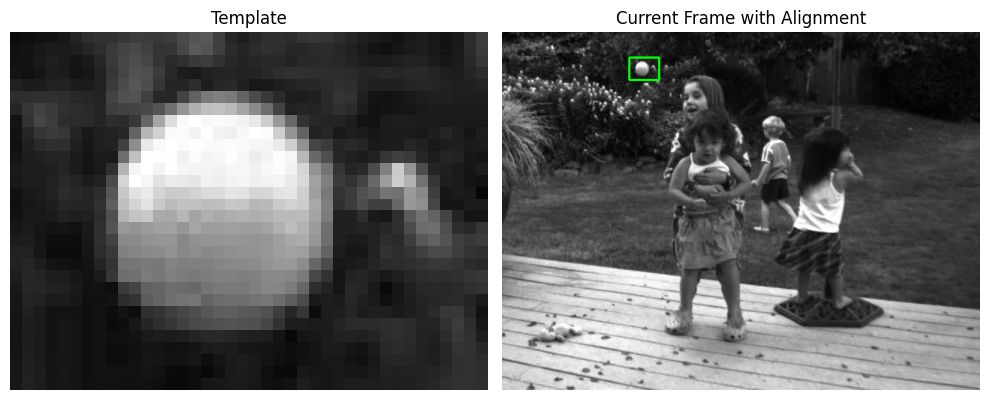

Reached maximum number of iterations without meeting epsilon.
Frame: frame08.png, Object coords: (x=161, y=25, w=40, h=30)


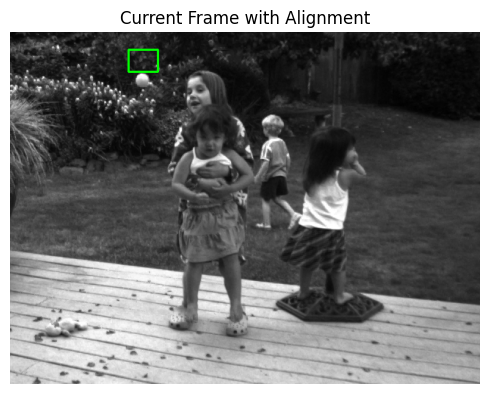

Converged within epsilon at iteration 77.
Frame: frame09.png, Object coords: (x=159, y=25, w=40, h=30)


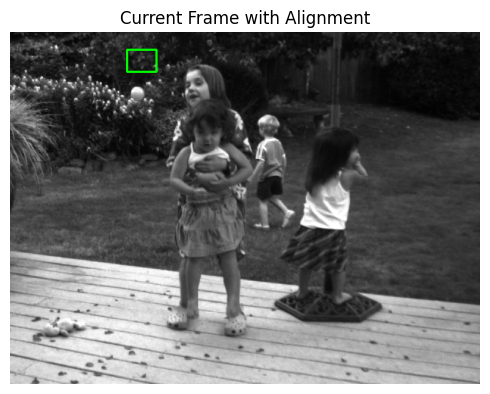

Converged within epsilon at iteration 71.
Frame: frame10.png, Object coords: (x=157, y=25, w=40, h=30)


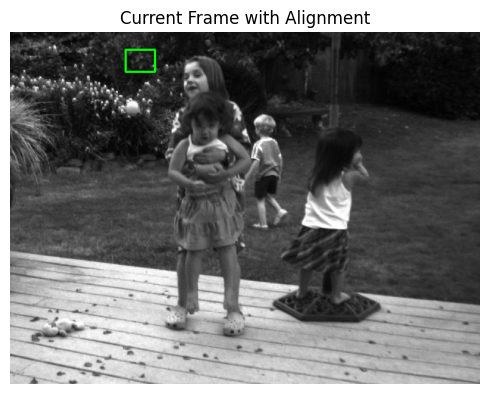

Converged within epsilon at iteration 68.
Frame: frame11.png, Object coords: (x=155, y=25, w=40, h=30)


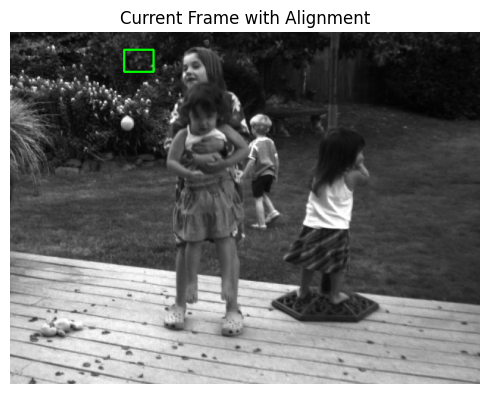

Converged within epsilon at iteration 77.
Frame: frame12.png, Object coords: (x=153, y=26, w=40, h=30)


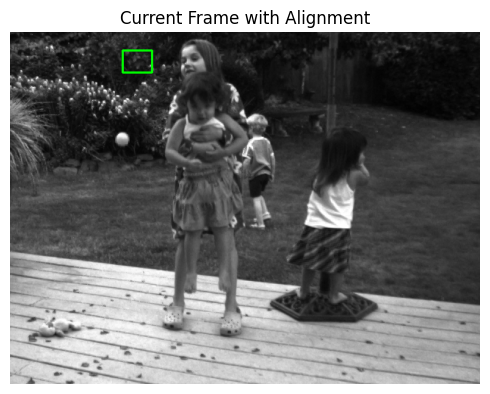

Converged within epsilon at iteration 53.
Frame: frame13.png, Object coords: (x=151, y=25, w=40, h=30)


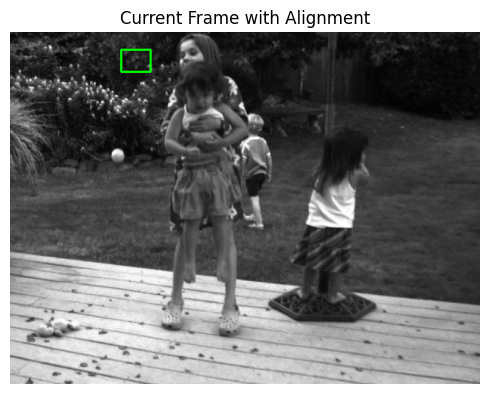

Converged within epsilon at iteration 67.
Frame: frame14.png, Object coords: (x=149, y=25, w=40, h=30)


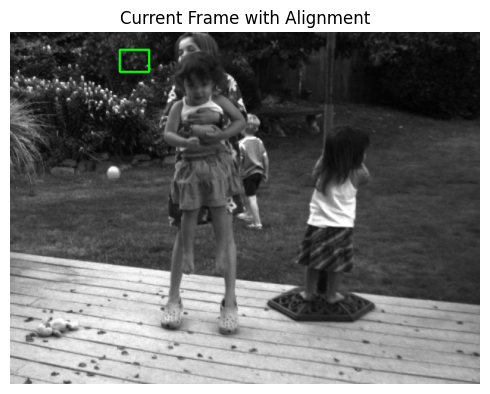

In [53]:
def compute_image_gradients(I):
    I = I.astype(np.float32)
    Ix = np.zeros_like(I, dtype=np.float32)
    Iy = np.zeros_like(I, dtype=np.float32)

    Ix[:, 1:-1] = (I[:, 2:] - I[:, :-2]) / 2.0
    Ix[:, 0] = I[:, 1] - I[:, 0]
    Ix[:, -1] = I[:, -1] - I[:, -2]

    Iy[1:-1, :] = (I[2:, :] - I[:-2, :]) / 2.0
    Iy[0, :] = I[1, :] - I[0, :]
    Iy[-1, :] = I[-1, :] - I[-2, :]

    return Ix, Iy

def bilinear_interpolate(I, X, Y):
    h, w = I.shape
    X0 = np.floor(X).astype(int)
    Y0 = np.floor(Y).astype(int)
    X1 = X0 + 1
    Y1 = Y0 + 1

    X0 = np.clip(X0, 0, w-1)
    X1 = np.clip(X1, 0, w-1)
    Y0 = np.clip(Y0, 0, h-1)
    Y1 = np.clip(Y1, 0, h-1)

    Ia = I[Y0, X0]
    Ib = I[Y0, X1]
    Ic = I[Y1, X0]
    Id = I[Y1, X1]

    wa = (X1 - X) * (Y1 - Y)
    wb = (X - X0) * (Y1 - Y)
    wc = (X1 - X) * (Y - Y0)
    wd = (X - X0) * (Y - Y0)

    return Ia*wa + Ib*wb + Ic*wc + Id*wd

def lucas_kanade_alignment(T, I_t1, rect, epsilon=1e-3, max_iterations=30, lambda_reg=1e-3):
    x, y, w, h = rect
    T_flat = T.flatten().astype(np.float32)
    Ix, Iy = compute_image_gradients(I_t1)

    X, Y = np.meshgrid(np.arange(w), np.arange(h))
    X = X.flatten().astype(np.float32)
    Y = Y.flatten().astype(np.float32)

    p = np.array([0.0, 0.0], dtype=np.float32)
    converged = False

    for iteration in range(max_iterations):
        X_w = X + x + p[0]
        Y_w = Y + y + p[1]

        Iw = bilinear_interpolate(I_t1, X_w, Y_w)
        Ix_w = bilinear_interpolate(Ix, X_w, Y_w)
        Iy_w = bilinear_interpolate(Iy, X_w, Y_w)

        error = (T_flat - Iw).reshape(-1, 1)
        A = np.column_stack((Ix_w, Iy_w))
        H = A.T @ A
        b = A.T @ error

        H_reg = H + lambda_reg * np.eye(2, dtype=np.float32)

        if np.linalg.cond(H_reg) < 1e12:
            dp = np.linalg.inv(H_reg) @ b
        else:
            dp = np.zeros((2,1), dtype=np.float32)

        dp = dp.flatten()
        p_new = p + dp

        if np.sqrt(dp[0]**2 + dp[1]**2) < epsilon:
            print(f"Converged within epsilon at iteration {iteration + 1}.")
            p = p_new
            converged = True
            break

        p = p_new

    if not converged and iteration + 1 == max_iterations:
        print("Reached maximum number of iterations without meeting epsilon.")
    elif converged and iteration + 1 == max_iterations:
        print("Converged at epsilon exactly at the maximum number of iterations.")

    return p

def visualize_alignment(I_t1, rect):
    x, y, w, h = rect
    I_t1_color = cv2.cvtColor(I_t1, cv2.COLOR_GRAY2BGR)
    cv2.rectangle(I_t1_color, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.figure(figsize=(5,5))
    plt.imshow(cv2.cvtColor(I_t1_color, cv2.COLOR_BGR2RGB))
    plt.title("Current Frame with Alignment")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_alignment_with_template(I_t1, T, rect):
    x, y, w, h = rect
    T_color = cv2.cvtColor(T, cv2.COLOR_GRAY2BGR)
    I_t1_color = cv2.cvtColor(I_t1, cv2.COLOR_GRAY2BGR)

    cv2.rectangle(I_t1_color, (x, y), (x + w, y + h), (0, 255, 0), 2)

    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    axs[0].imshow(cv2.cvtColor(T_color, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Template")
    axs[0].axis('off')

    axs[1].imshow(cv2.cvtColor(I_t1_color, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Current Frame with Alignment")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    crop1 = (265, 140, 100, 240)
    crop2 = (170, 35, 40, 30)
    crop3 = (45, 210, 40, 25)
    x, y, w, h = crop2

    template_path = "/Users/yaseminakin/Desktop/HW3/dataset/cropped/crop2.jpg"
    T = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
    if T is None:
        raise IOError("Could not load template image: {}".format(template_path))

    h_T, w_T = T.shape[:2]
    if w_T != w or h_T != h:
        print("Warning: Template dimensions differ from (w,h). Using actual template size from crop image.")
        w, h = w_T, h_T

    seq_folder = "/Users/yaseminakin/Desktop/HW3/dataset/videos/2"
    frames = glob.glob(os.path.join(seq_folder, "*.png"))
    frames.sort(key=lambda f: tuple(int(n) for n in re.findall(r'\d+', os.path.splitext(os.path.basename(f))[0])) 
             or [os.path.splitext(os.path.basename(f))[0]])
    if len(frames) == 0:
        raise ValueError("No frames found for the specified pattern.")

    epsilon = 1e-5
    max_iterations = 100
    lambda_reg = 0

    current_x, current_y = x, y

    # For each subsequent frame, align and update coordinates
    for i, frame_path in enumerate(frames):
        I_t1 = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
        if I_t1 is None:
            raise IOError("Could not load image: {}".format(frame_path))

        if i == 0:
            
            print(f"Template Frame (visualizing the initial alignment here): {os.path.basename(frame_path)}, Object coords: (x={current_x}, y={current_y}, w={w}, h={h})")
            visualize_alignment_with_template(I_t1, T, (current_x, current_y, w, h))
        else:
            dp = lucas_kanade_alignment(T, I_t1, (current_x, current_y, w, h), epsilon=epsilon, max_iterations=max_iterations, lambda_reg=lambda_reg)

            current_x = int(round(current_x + dp[0]))
            current_y = int(round(current_y + dp[1]))

            print(f"Frame: {os.path.basename(frame_path)}, Object coords: (x={current_x}, y={current_y}, w={w}, h={h})")

            visualize_alignment(I_t1, (current_x, current_y, w, h))

## Implementation of Pyramidal Lucas-Kanade Alignment

Template Frame (visualizing the initial alignment here): 1.png, Object coords: (x=45, y=210, w=40, h=25)


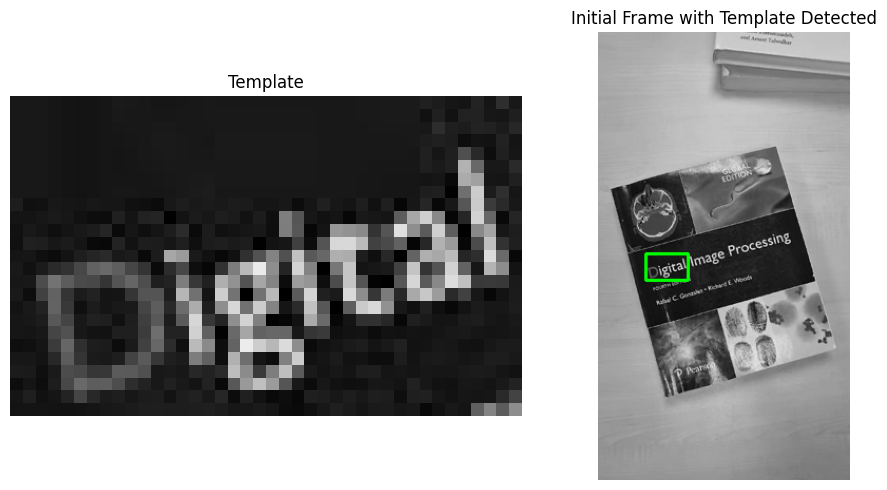

At level: 2
Converged within epsilon at iteration 31.
At level: 1
Converged within epsilon at iteration 16.
At level: 0
Converged within epsilon at iteration 14.
Frame: 2.png, Object coords: (x=46, y=203, w=40, h=25)
At level: 2
Converged within epsilon at iteration 34.
At level: 1
Converged within epsilon at iteration 16.
At level: 0
Converged within epsilon at iteration 10.
Frame: 3.png, Object coords: (x=50, y=196, w=40, h=25)
At level: 2
Converged within epsilon at iteration 28.
At level: 1
Converged within epsilon at iteration 19.
At level: 0
Converged within epsilon at iteration 12.
Frame: 4.png, Object coords: (x=52, y=190, w=40, h=25)
At level: 2
Converged within epsilon at iteration 32.
At level: 1
Converged within epsilon at iteration 15.
At level: 0
Converged within epsilon at iteration 17.
Frame: 5.png, Object coords: (x=52, y=183, w=40, h=25)
At level: 2
Converged within epsilon at iteration 32.
At level: 1
Converged within epsilon at iteration 10.
At level: 0
Converged wi

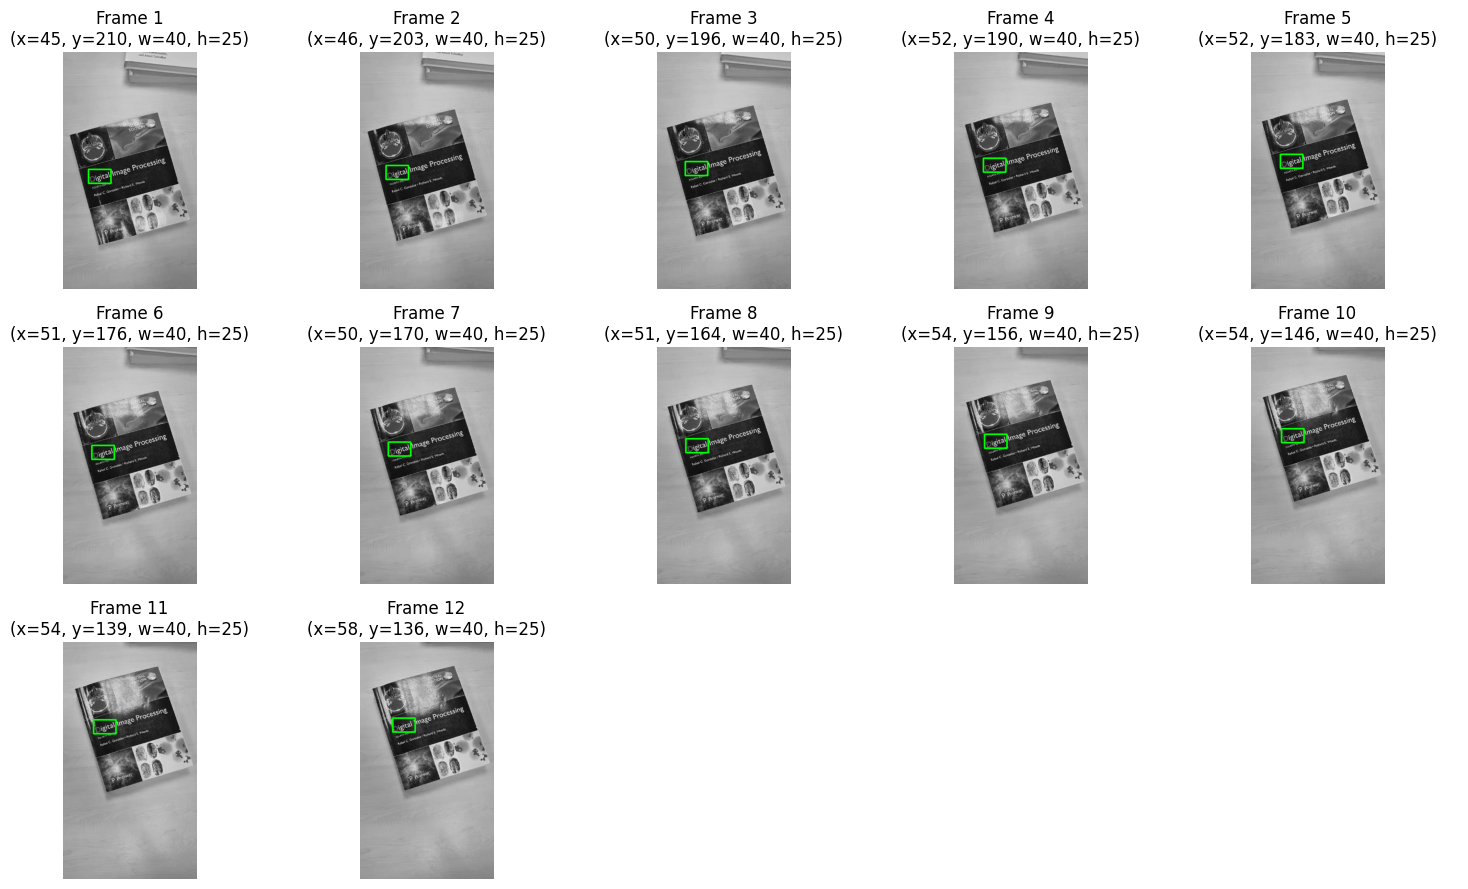

In [ ]:
def convolve(I, kernel):
    h, w = I.shape
    kh, kw = kernel.shape
    pad_h, pad_w = kh//2, kw//2
    I_padded = np.pad(I, ((pad_h, pad_h), (pad_w, pad_w)), mode='edge')
    output = np.zeros_like(I, dtype=np.float32)
    for y in range(h):
        for x in range(w):
            region = I_padded[y:y+kh, x:x+kw]
            output[y, x] = np.sum(region * kernel)
    return output

def gaussian_blur(I):
    gauss_kernel = np.array([[1, 2, 1],
                             [2,4, 2],
                             [1, 2, 1]], dtype=np.float32)
    gauss_kernel = gauss_kernel / np.sum(gauss_kernel)
    return convolve(I, gauss_kernel)

def compute_image_gradients(I):
    I = I.astype(np.float32)
    # I = gaussian_blur(I)

    Gx = np.array([[-1,0,1],
                   [-2,0,2],
                   [-1,0,1]], dtype=np.float32)

    Gy = np.array([[-1,-2,-1],
                   [0,  0,  0],
                   [1,  2,  1]], dtype=np.float32)

    Ix = convolve(I, Gx)
    Iy = convolve(I, Gy)
    return Ix, Iy

def bilinear_interpolate(I, X, Y):
    h, w = I.shape
    X0 = np.floor(X).astype(int)
    Y0 = np.floor(Y).astype(int)
    X1 = X0 + 1
    Y1 = Y0 + 1

    X0 = np.clip(X0, 0, w-1)
    X1 = np.clip(X1, 0, w-1)
    Y0 = np.clip(Y0, 0, h-1)
    Y1 = np.clip(Y1, 0, h-1)

    Ia = I[Y0, X0]
    Ib = I[Y0, X1]
    Ic = I[Y1, X0]
    Id = I[Y1, X1]

    wa = (X1 - X) * (Y1 - Y)
    wb = (X - X0) * (Y1 - Y)
    wc = (X1 - X) * (Y - Y0)
    wd = (X - X0) * (Y - Y0)

    return Ia*wa + Ib*wb + Ic*wc + Id*wd

def build_pyramid(I, levels=3):
    pyramid = [I.astype(np.float32)]
    for _ in range(1, levels):
        prev = pyramid[-1]
        blurred = gaussian_blur(prev)
        down = blurred[::2, ::2]
        pyramid.append(down)
    return pyramid

def lucas_kanade_single_scale(T, I_t1, rect, epsilon=1e-3, max_iterations=30, lambda_reg=1e-3):
    
    x, y, w, h = rect
    T_flat = T.flatten().astype(np.float32)
    Ix, Iy = compute_image_gradients(I_t1)

    X, Y = np.meshgrid(np.arange(w), np.arange(h))
    X = X.flatten().astype(np.float32)
    Y = Y.flatten().astype(np.float32)

    p = np.array([0.0, 0.0], dtype=np.float32)
    converged = False

    for iteration in range(max_iterations):
        X_w = X + x + p[0]
        Y_w = Y + y + p[1]

        Iw = bilinear_interpolate(I_t1, X_w, Y_w)
        Ix_w = bilinear_interpolate(Ix, X_w, Y_w)
        Iy_w = bilinear_interpolate(Iy, X_w, Y_w)

        error = (T_flat - Iw).reshape(-1, 1)
        A = np.column_stack((Ix_w, Iy_w))
        H = A.T @ A
        b = A.T @ error

        H_reg = H + lambda_reg * np.eye(2, dtype=np.float32)

        if np.linalg.cond(H_reg) < 1e12:
            dp = np.linalg.inv(H_reg) @ b
        else:
            dp = np.zeros((2,1), dtype=np.float32)

        dp = dp.flatten()
        p_new = p + dp

        if np.sqrt(dp[0]**2 + dp[1]**2) < epsilon:
            print(f"Converged within epsilon at iteration {iteration + 1}.")
            p = p_new
            converged = True
            break

        p = p_new

    if not converged and iteration + 1 == max_iterations:
        print("Reached maximum number of iterations without meeting epsilon.")
    elif converged and iteration + 1 == max_iterations:
        print("Converged at epsilon exactly at the maximum number of iterations.")

    return p

def lucas_kanade_pyramidal(T, I_t1, rect, levels=3, epsilon=1e-3, max_iterations=30, lambda_reg=1e-3):
    x, y, w, h = rect

    T_pyr = build_pyramid(T, levels=levels)
    I_pyr = build_pyramid(I_t1, levels=levels)

    p = np.array([0.0, 0.0], dtype=np.float32)

    scale_factors = [2**(-i) for i in range(levels)]

    for level in reversed(range(levels)):
        print(f"At level: {level}")
        scale = scale_factors[level]

        h_level, w_level = T_pyr[level].shape
        current_w = w_level
        current_h = h_level

        current_x = (x + p[0]) * scale
        current_y = (y + p[1]) * scale

        I_level = I_pyr[level]
        T_level = T_pyr[level]

        current_x = np.clip(current_x, 0, I_level.shape[1] - current_w)
        current_y = np.clip(current_y, 0, I_level.shape[0] - current_h)

        dp = lucas_kanade_single_scale(T_level, I_level,
                                       (current_x, current_y, current_w, current_h),
                                       epsilon=epsilon, max_iterations=max_iterations, lambda_reg=lambda_reg)

        p[0] += dp[0] / scale
        p[1] += dp[1] / scale

    return p

def visualize_alignment(I_t1, rect):
    x, y, w, h = rect
    I_t1_color = cv2.cvtColor(I_t1, cv2.COLOR_GRAY2BGR)
    cv2.rectangle(I_t1_color, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.figure(figsize=(5,5))
    plt.imshow(cv2.cvtColor(I_t1_color, cv2.COLOR_BGR2RGB))
    plt.title("Current Frame with Alignment")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_alignment_with_template(I_t1, T, rect):
    x, y, w, h = rect
    T_color = cv2.cvtColor(T, cv2.COLOR_GRAY2BGR)
    I_t1_color = cv2.cvtColor(I_t1, cv2.COLOR_GRAY2BGR)

    cv2.rectangle(I_t1_color, (x, y), (x + w, y + h), (0, 255, 0), 2)

    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    axs[0].imshow(cv2.cvtColor(T_color, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Template")
    axs[0].axis('off')

    axs[1].imshow(cv2.cvtColor(I_t1_color, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Initial Frame with Template Detected")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

def visualize_all_alignments(frames, bounding_boxes):
    
    num_frames = len(frames)
    cols = 5
    rows = (num_frames + cols - 1) // cols  

    fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 3))
    axs = axs.flatten()

    for i, (frame_path, bbox) in enumerate(zip(frames, bounding_boxes)):
        I_t1 = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
        if I_t1 is None:
            axs[i].axis('off')
            continue

        I_t1_color = cv2.cvtColor(I_t1, cv2.COLOR_GRAY2BGR)
        x, y, w, h = bbox
        cv2.rectangle(I_t1_color, (x, y), (x + w, y + h), (0, 255, 0), 2)

        axs[i].imshow(cv2.cvtColor(I_t1_color, cv2.COLOR_BGR2RGB))
        axs[i].set_title(f"Frame {i + 1}\n(x={x}, y={y}, w={w}, h={h})")
        axs[i].axis('off')

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    
    crop1 = (265, 140, 100, 240)
    crop2 = (170, 35, 40, 30)
    crop3 = (45, 210, 40, 25)
    x, y, w, h = crop3
    template_path = "/Users/yaseminakin/Desktop/HW3/dataset/cropped/crop3.jpg"
    T = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
    if T is None:
        raise IOError("Could not load template image.")

    h_T, w_T = T.shape[:2]
    w, h = w_T, h_T
    seq_folder = "/Users/yaseminakin/Desktop/HW3/dataset/videos/3"
    frames = glob.glob(os.path.join(seq_folder, "*.png"))
    frames.sort(key=lambda f: tuple(int(n) for n in re.findall(r'\d+', os.path.splitext(os.path.basename(f))[0])) 
             or [os.path.splitext(os.path.basename(f))[0]])

    epsilon = 1e-3
    max_iterations = 100000
    lambda_reg = 0
    pyramid_levels = 3 

    current_x, current_y = x, y
    bounding_boxes = []

    for i, frame_path in enumerate(frames):
        I_t1 = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
        if I_t1 is None:
            raise IOError("Could not load image: {}".format(frame_path))

        if i == 0:
            print(f"Template Frame (visualizing the initial alignment here): {os.path.basename(frame_path)}, Object coords: (x={current_x}, y={current_y}, w={w}, h={h})")
            visualize_alignment_with_template(I_t1, T, (current_x, current_y, w, h))
            bounding_boxes.append((current_x, current_y, w, h))

        else:
            dp = lucas_kanade_pyramidal(T, I_t1, (current_x, current_y, w, h),
                                        levels=pyramid_levels, epsilon=epsilon,
                                        max_iterations=max_iterations, lambda_reg=lambda_reg)

            current_x = int(round(current_x + dp[0]))
            current_y = int(round(current_y + dp[1]))

            print(f"Frame: {os.path.basename(frame_path)}, Object coords: (x={current_x}, y={current_y}, w={w}, h={h})")
            bounding_boxes.append((current_x, current_y, w, h))
            # visualize_alignment(I_t1, (current_x, current_y, w, h))
    
    visualize_all_alignments(frames, bounding_boxes)


In [109]:
%matplotlib inline 

## Implementation of Pyramidal Kanade-Lucas-Tomasi (KLT) Tracker

Frame frame08.png: Converged within epsilon at iteration 114.
Frame frame08.png: Converged within epsilon at iteration 126.
Frame frame08.png: Converged within epsilon at iteration 52.
Frame frame08.png: Converged within epsilon at iteration 122.
Frame frame08.png: Converged within epsilon at iteration 765.
Frame frame08.png: Converged within epsilon at iteration 53.
Frame frame08.png: Converged within epsilon at iteration 115.
Frame frame08.png: Converged within epsilon at iteration 200.
Frame frame08.png: Converged within epsilon at iteration 58.
Frame frame08.png: Converged within epsilon at iteration 148.
Frame frame08.png: Converged within epsilon at iteration 202.
Frame frame08.png: Converged within epsilon at iteration 46.
Frame frame08.png: Converged within epsilon at iteration 83.
Frame frame08.png: Converged within epsilon at iteration 67.
Frame frame08.png: Converged within epsilon at iteration 56.
Frame frame08.png: Converged within epsilon at iteration 125.
Frame frame08.p

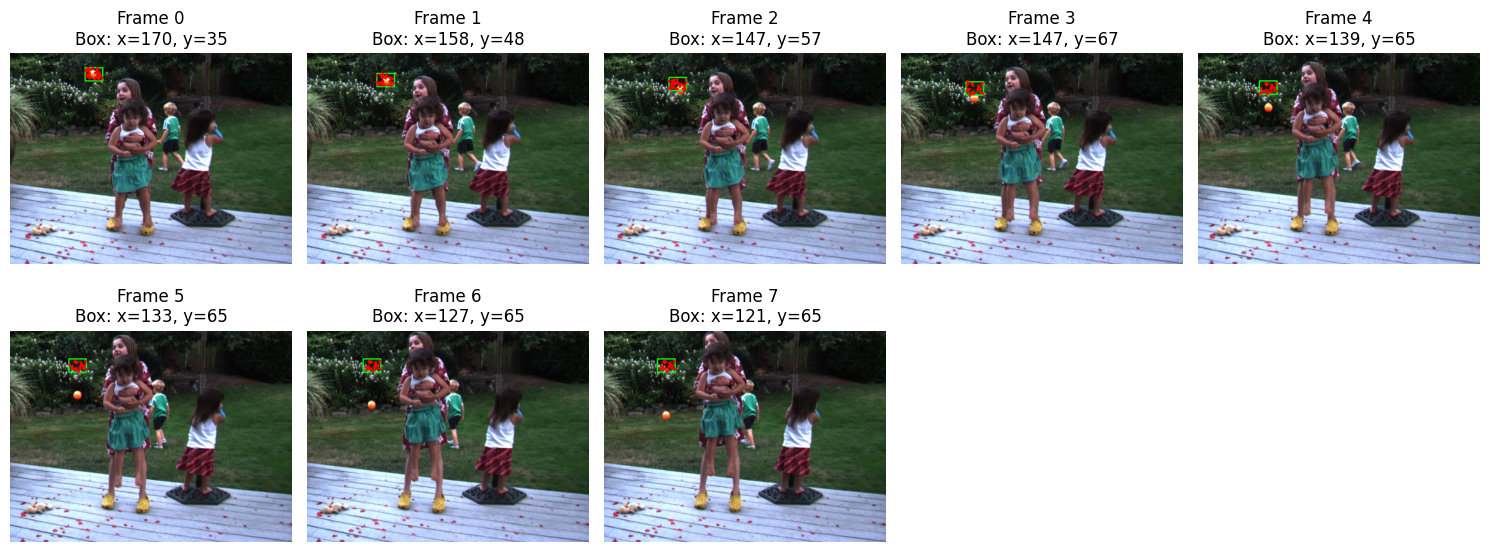

In [214]:
def gaussian_blur(I):
    return cv2.GaussianBlur(I, (3,3), sigmaX=1, sigmaY=1)

def compute_image_gradients(I):
    I = I.astype(np.float32)
    Ix = cv2.Sobel(I, cv2.CV_32F, 1, 0, ksize=3)
    Iy = cv2.Sobel(I, cv2.CV_32F, 0, 1, ksize=3)
    return Ix, Iy

def bilinear_interpolate(I, X, Y):
    h, w = I.shape
    X0 = np.floor(X).astype(np.int32)
    Y0 = np.floor(Y).astype(np.int32)
    X1 = X0 + 1
    Y1 = Y0 + 1

    X0 = np.clip(X0, 0, w-1)
    X1 = np.clip(X1, 0, w-1)
    Y0 = np.clip(Y0, 0, h-1)
    Y1 = np.clip(Y1, 0, h-1)

    Ia = I[Y0, X0]
    Ib = I[Y0, X1]
    Ic = I[Y1, X0]
    Id = I[Y1, X1]

    wa = (X1 - X) * (Y1 - Y)
    wb = (X - X0) * (Y1 - Y)
    wc = (X1 - X) * (Y - Y0)
    wd = (X - X0) * (Y - Y0)

    return Ia*wa + Ib*wb + Ic*wc + Id*wd

def build_pyramid(I, levels=3):
    pyramid = [I]
    for _ in range(1, levels):
        I_blur = cv2.GaussianBlur(I, (3,3), sigmaX=1, sigmaY=1)
        I = I_blur[::2, ::2]
        pyramid.append(I)
    return pyramid

def harris_corners(I, window_size=3, k=0.04, threshold=1e-5):
    Ix, Iy = compute_image_gradients(I)
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy

    Ixx = gaussian_blur(Ixx)
    Iyy = gaussian_blur(Iyy)
    Ixy = gaussian_blur(Ixy)

    R = (Ixx * Iyy - Ixy**2) - k*(Ixx + Iyy)**2

    corners = []
    offset = window_size//2
    for y in range(offset, I.shape[0]-offset):
        for x in range(offset, I.shape[1]-offset):
            val = R[y,x]
            if val > threshold:
                window = R[y-offset:y+offset+1, x-offset:x+offset+1]
                if val == np.max(window):
                    corners.append((x,y,val))

    corners.sort(key=lambda c: c[2], reverse=True)
    return corners

def lucas_kanade_point(I_prev, I_curr, Ix, Iy, x, y, window_size=15, epsilon=1e-3, max_iterations=30, frame_name="Unknown Frame"):
    half_w = window_size // 2
    p = np.array([0.0, 0.0], dtype=np.float32)

    X, Y = np.meshgrid(np.arange(-half_w, half_w + 1), np.arange(-half_w, half_w + 1))
    X = X.flatten().astype(np.float32)
    Y = Y.flatten().astype(np.float32)

    Xp = X + x
    Yp = Y + y
    T = bilinear_interpolate(I_prev, Xp, Yp)

    converged = False
    for iteration in range(max_iterations):
        X_w = X + x + p[0]
        Y_w = Y + y + p[1]

        Iw = bilinear_interpolate(I_curr, X_w, Y_w)
        Ix_w = bilinear_interpolate(Ix, X_w, Y_w)
        Iy_w = bilinear_interpolate(Iy, X_w, Y_w)

        error = (T - Iw).reshape(-1, 1)
        A = np.column_stack((Ix_w, Iy_w))
        H = A.T @ A
        b = A.T @ error

        if np.linalg.cond(H) < 1e12:
            dp = np.linalg.inv(H) @ b
        else:
            dp = np.zeros((2, 1), dtype=np.float32)
        dp = dp.flatten()

        p += dp

        if (dp[0]**2 + dp[1]**2) < epsilon**2:
            print(f"Frame {frame_name}: Converged within epsilon at iteration {iteration + 1}.")
            converged = True
            break

    if not converged:
        print(f"Frame {frame_name}: Reached maximum number of iterations without meeting epsilon.")
    elif converged and iteration + 1 == max_iterations:
        print(f"Frame {frame_name}: Converged at epsilon exactly at the maximum number of iterations.")

    return x + p[0], y + p[1]

def lucas_kanade_point_pyramid(I_prev, I_curr, x, y, levels=3, window_size=15, epsilon=1e-3, max_iterations=30, frame_name="Unknown Frame"):
    pyr_prev = build_pyramid(I_prev, levels=levels)
    pyr_curr = build_pyramid(I_curr, levels=levels)

    p = np.array([0.0, 0.0], dtype=np.float32)

    for level in reversed(range(levels)):
        scale = 2**(-level)
        x_level = (x + p[0]) * scale
        y_level = (y + p[1]) * scale

        I_prev_level = pyr_prev[level]
        I_curr_level = pyr_curr[level]

        Ix_level, Iy_level = compute_image_gradients(I_curr_level)

        x_new, y_new = lucas_kanade_point(I_prev_level, I_curr_level, Ix_level, Iy_level,
                                          x_level, y_level, window_size=window_size,
                                          epsilon=epsilon, max_iterations=max_iterations,
                                          frame_name=frame_name)

        p[0] += (x_new - x_level) / scale
        p[1] += (y_new - y_level) / scale

    return x + p[0], y + p[1]

def track_corners_klt(frames, bounding_box, harris_thresh=1e-5, harris_k=0.04, corner_count=50, 
                      epsilon=1e-3, max_iterations=30, re_detection_rate=5, window_size=15, pyramid_levels=3):
    x, y, w, h = bounding_box

    I0 = cv2.imread(frames[0], cv2.IMREAD_GRAYSCALE)
    if I0 is None:
        raise IOError(f"Could not load frame {frames[0]}")

    corners = harris_corners(I0, threshold=harris_thresh, k=harris_k)
    corners_inside = [(cx, cy) for (cx, cy, _) in corners if x <= cx < x+w and y <= cy < y+h]
    corners_inside = corners_inside[:corner_count]

    tracked_boxes = [(x, y, w, h)]
    all_corners_per_frame = [corners_inside.copy()]
    prev_frame = I0.copy()

    for i, f in enumerate(frames[1:], start=1):
        I = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        if I is None:
            raise IOError(f"Could not load frame {f}")

        new_corners = []
        displacements = []
        for (cx, cy) in corners_inside:
            nx, ny = lucas_kanade_point_pyramid(prev_frame, I, cx, cy,
                                                levels=pyramid_levels,
                                                window_size=window_size,
                                                epsilon=epsilon,
                                                max_iterations=max_iterations,
                                                frame_name=os.path.basename(f))
            new_corners.append((nx, ny))
            displacements.append((nx - cx, ny - cy))

        if len(displacements) > 0:
            dx_vals = [d[0] for d in displacements]
            dy_vals = [d[1] for d in displacements]
            median_dx = np.median(dx_vals)
            median_dy = np.median(dy_vals)

            abs_dev_dx = [abs(dx - median_dx) for dx in dx_vals]
            abs_dev_dy = [abs(dy - median_dy) for dy in dy_vals]

            thr = 5.0 * np.mean(abs_dev_dx + abs_dev_dy) if len(abs_dev_dx+abs_dev_dy) > 0 else 0

            filtered_corners = []
            filtered_displacements = []
            for (nx, ny), (dx, dy) in zip(new_corners, displacements):
                dev = abs(dx - median_dx) + abs(dy - median_dy)
                if dev < thr:
                    filtered_corners.append((nx, ny))
                    filtered_displacements.append((dx, dy))
            new_corners = filtered_corners
            displacements = filtered_displacements
        else:
            new_corners = []
            displacements = []

        stable_corners = [(nx, ny) for (nx, ny) in new_corners if x <= nx < x+w and y <= ny < y+h]
        new_corners = stable_corners

        if len(displacements) > 0:
            dx_vals = [d[0] for d in displacements]
            dy_vals = [d[1] for d in displacements]
            box_dx = np.median(dx_vals)  
            box_dy = np.median(dy_vals) 

        else:
            box_dx, box_dy = 0, 0

        x += box_dx
        y += box_dy
        x, y = int(round(x)), int(round(y))

        corners_inside = new_corners

        if (i % re_detection_rate) == 0 or len(corners_inside) < corner_count:
            corners = harris_corners(I, threshold=harris_thresh, k=harris_k)
            new_candidates = [(cx, cy) for (cx, cy, _) in corners if x <= cx < x+w and y <= cy < y+h]
            needed = corner_count - len(corners_inside)
            corners_inside.extend(new_candidates[:needed])

        tracked_boxes.append((x, y, w, h))
        prev_frame = I
        all_corners_per_frame.append(corners_inside.copy())

    return tracked_boxes, all_corners_per_frame

def visualize_tracking(frames, tracked_boxes, all_corners_per_frame, save_images=False, out_dir="output"):
    if save_images and not os.path.exists(out_dir):
        os.makedirs(out_dir)

    all_results = []

    for i, f in enumerate(frames):
        I = cv2.imread(f)
        if I is None:
            continue
        (x, y, w, h) = tracked_boxes[i]
        corners = all_corners_per_frame[i]

        print(f"Frame {i}: Bounding Box -> x={x}, y={y}, w={w}, h={h}")
        cv2.rectangle(I, (x, y), (x+w, y+h), (0,255,0), 2)
        for (cx, cy) in corners:
            cv2.circle(I, (int(round(cx)), int(round(cy))), 3, (0,0,255), -1)

        all_results.append(I)

        if save_images:
            out_path = os.path.join(out_dir, f"tracked_{i:04d}.png")
            cv2.imwrite(out_path, I)

    cols = 5
    rows = (len(all_results) + cols - 1) // cols

    plt.figure(figsize=(15, rows * 3))
    for i, result in enumerate(all_results):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.title(f"Frame {i}\nBox: x={tracked_boxes[i][0]}, y={tracked_boxes[i][1]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    video_folder = "/Users/yaseminakin/Desktop/HW3/dataset/videos/2"
    frames = sorted(glob.glob(os.path.join(video_folder, "*.png")), 
                    key=lambda f: int(re.findall(r'\d+', os.path.basename(f))[0]))
    crop1 = (265, 140, 100, 240)
    crop2 = (170, 35, 40, 30)
    crop3 = (45, 210, 40, 25)
    bounding_box = crop2

    harris_thresh = 1e-3
    harris_k = 0.05
    corner_count = 30
    epsilon = 1e-4
    max_iterations = 100000
    re_detection_rate = 2
    window_size = 15
    pyramid_levels = 3

    tracked_boxes, all_corners_per_frame = track_corners_klt(
        frames, bounding_box,
        harris_thresh=harris_thresh,
        harris_k=harris_k,
        corner_count=corner_count,
        epsilon=epsilon,
        max_iterations=max_iterations,
        re_detection_rate=re_detection_rate,
        window_size=window_size,
        pyramid_levels=pyramid_levels
    )

    visualize_tracking(frames, tracked_boxes, all_corners_per_frame, save_images=False)